### Analyzing the effect of age on freezing beahvior.
This needs to be double checked. and need to add the learing too.
* 8/21 refactoring as per the structure of the sleep repo
* also tweaked here and there. now it separates 2 age groups not 3. save folder also changed temporalily.

In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 273 (delta 15), reused 20 (delta 8), pack-reused 242
Receiving objects: 100% (273/273), 1.08 MiB | 2.93 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=1000 sha256=8a063a93b52807f94e685b4e38e537e2b737fe170f623a27e5b916984b199444
  Stored in directory: /tmp/pip-ephem-wheel-cache-fpnatv5_/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [ ]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns

import statsmodels.api as sm

from sleep.base import core

sns.set_context('paper', font_scale=0.85)
import pandas as pd
from datetime import date
%matplotlib inline

In [ ]:
dr = core.GoogleDrive()
gdrive  = dr.mount_drive()

Mounted at /gdrive


In [ ]:
save_dir = '/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/!analysis/saveFolder/R21_NCE_08_2023'

In [ ]:
def age_selector(row):
    if row<= 12:
        return 'young adult'
    # elif 12< row <= 16:
    #     return 'middle'
    elif row> 12: #16
        return 'adult'

In [ ]:
data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')

In [ ]:
# converting number strings to number
data = data.copy()
data.replace('NA', np.NaN, inplace=True)
data[['freezing']] = data[['freezing']].apply(pd.to_numeric)
data = data[(data['els']=='n') &
            (data['psilocybin']=='n')]
data['cohort_id'] = data['cohort']+'_'+data['id']

cohort_list = ['ptsd2', 'ptsd3', 'ptsd4','ptsd5',
               'ptsd6', 'ptsd8', 'ptsd9', 'ptsd10', 'els1']
daylist=['sefla', 'seflb', 'recall1', 'recall2',
         'recall3', 'recall4', 'recall5']

df_select = data[(data['day'].isin(daylist)) &
        (data['cohort'].isin(cohort_list))]

df_select.head(2)

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id
73,5.03,wt,81,sefla,control,male,ptsd2,60,60,4/28/2021,11:59 AM,n,n,ptsd2_81
74,8.83,wt,82,sefla,control,male,ptsd2,60,60,4/28/2021,11:59 AM,n,n,ptsd2_82


<ipython-input-23-aba4e11a9983>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=daylist, rotation=30, fontsize=10)


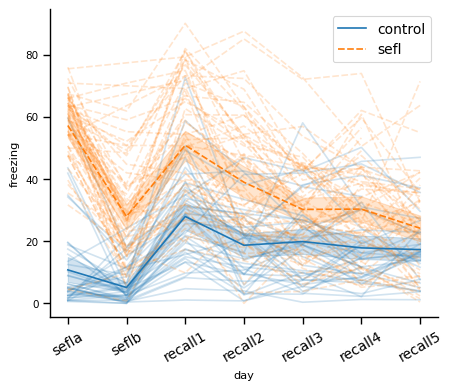

In [ ]:
df = df_select
f, ax = plt.subplots(figsize=(5,4))
g = sns.lineplot(data=df, x='day', y='freezing', hue='condition',
                 units='cohort_id', estimator=None, style='condition', alpha=.2,
                 ax=ax)
g = sns.lineplot(data=df, x='day', y='freezing', hue='condition',
                 style='condition', legend=False, ax=ax)
g.set_xticklabels(labels=daylist, rotation=30, fontsize=10)
plt.legend(fontsize=10)
sns.despine()

In [ ]:
age_at_sefla = dr.load_spreadsheet_data('age_at_sefla', sheet='age_at_sefla')
age_at_sefla.set_index('cohort_id', inplace=True, drop=True)
age_at_sefla['age_at_SEFLA'] = age_at_sefla['age_at_SEFLA'].apply(pd.to_numeric)
age_at_sefla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, ptsd1_5HT2Afl05a-5 to els1_921-4
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age_at_SEFLA  117 non-null    float64
dtypes: float64(1)
memory usage: 1.8+ KB


In [ ]:
df_select_age = df_select.set_index('cohort_id').join(age_at_sefla,
                                                      how='inner')
df_select_age['age cat'] = df_select_age[
                                         'age_at_SEFLA'].apply(
                                             lambda x: age_selector(x))
df_select_age.head(2)

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,age_at_SEFLA,age cat
cohort_id,,,,,,,,,,,,,,,
els1_921-2,3.93,wt,921-2,sefla,control,female,els1,,,2/19/22,,n,n,16.714286,adult
els1_921-2,11.70,wt,921-2,seflb,control,female,els1,,,2/20/22,,n,n,16.714286,adult


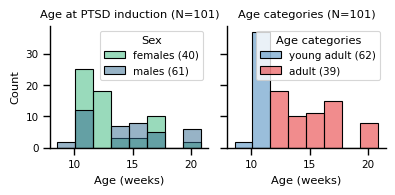

In [ ]:
# plot1
df=df_select_age[df_select_age['day']=='sefla'].reset_index()
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()
num_groups = df.groupby(['age cat'])['cohort_id'].nunique()
num_mice = df.cohort_id.nunique()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(4,2), sharey=True,
                       tight_layout=True)
d = sns.histplot(df, x='age_at_SEFLA', hue='sex', palette="viridis",
                legend=False, ax=ax[0])
d.set_title('Age at PTSD induction (N=%s)' %num_mice)
d.set(xlabel='Age (weeks)')

d.legend(title='Sex', loc='upper right', labels=['females (%s)' % num_sexes[0],
                                                   'males (%s)' % num_sexes[1]])
d = sns.histplot(df, x='age_at_SEFLA', hue='age cat', palette="Set1",
                legend=False, ax=ax[1])
d.set_title('Age categories (N=%s)' %num_mice)

d.legend(title='Age categories', loc='upper right', labels=['young adult (%s)' % num_groups[0],
                                                   'adult (%s)' % num_groups[1]])
d.set(xlabel='Age (weeks)')
sns.despine()
fig.savefig(join(save_dir, 'Distribution of age at PTSD induction - 2groups.png'),
          dpi=300, transparent=True, bbox_inches='tight')

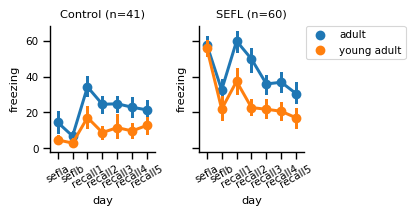

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.2,2.2),
                     tight_layout=True, sharey=True)

# upper left
df=df_select_age[df_select_age['condition']=='control'].reset_index()
# g = sns.lineplot(data=df, x='day', y='freezing', hue='age cat',
#                  units='cohort_id', estimator=None, alpha=.2,
#                  ax=ax[0])
g = sns.pointplot(data=df, x='day', y='freezing', hue='age cat',
                 ax=ax[0])
g.legend().remove()
g.set_title(label='Control (n={})'.format(df['cohort_id'].nunique()))
g.set_xticklabels(labels=daylist, rotation=30) #fontsize=

# upper right
df=df_select_age[df_select_age['condition']=='sefl'].reset_index()
# g = sns.lineplot(data=df, x='day', y='freezing', hue='age cat',
#                  units='cohort_id', estimator=None, alpha=.2,
#                  ax=ax[1])
g = sns.pointplot(data=df, x='day', y='freezing', hue='age cat',
                 ax=ax[1])
g.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g.set_xticklabels(labels=daylist, rotation=30) #fontsize=
g.set_title(label='SEFL (n={})'.format(df['cohort_id'].nunique()))

# # lower left
# df=df_select_age[(df_select_age['condition']=='sefl') &
#             (df_select_age['day']=='recall5')].reset_index()

# g = sns.swarmplot(data=df, x='age cat',y='freezing',
#               color='.2', ax=ax[1][0])

# g = sns.pointplot(data=df, x='age cat',y='freezing',
#                    join=False, ax=ax[1][0])
# g.set_title(label='SEFL - Last recall (5) freezing (n={})'.format(df['cohort_id'].nunique()))

# # lower right
# df=df_select_age[(df_select_age['condition']=='control') &
#             (df_select_age['day']=='recall5')].reset_index()

# g = sns.swarmplot(data=df, x='age cat',y='freezing',
#               color='.2', ax=ax[1][1])

# g = sns.pointplot(data=df, x='age cat',y='freezing',
#                    join=False, ax=ax[1][1])
# g.set_title(label='Ctrl - Last recall (5) freezing (n={})'.format(df['cohort_id'].nunique()))

sns.despine()

f.savefig(join(save_dir, 'Effect of age on freezing - 2 groups.png'),
          dpi=300, transparent=True, bbox_inches='tight')

#### Learning -- i have not modified this part yet (8/21)

In [ ]:
learning_data = dr.load_spreadsheet_data('Learing_slopes_pre_sock06')

SpreadsheetNotFound: ignored

In [ ]:
worksheet = gc.open('Learing_slopes_pre_sock06').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)
# Convert to a DataFrame and render.
learning_df = pd.DataFrame.from_records(data)
learning_df.columns = learning_df.iloc[0]
learning_df.drop(learning_df.index[0], inplace=True)
learning_df.reset_index(inplace=True, drop=True)
learning_df.drop([''], axis=1, inplace=True)
learning_df['slope'] = pd.to_numeric(learning_df['slope'],
                                        downcast='float')
learning_df['sex']=learning_df['sex'].str.lower()
learning_df.set_index('cohort_id', inplace=True)
learning_df.head()

,group,sex,els,dob,genotype,slope
cohort_id,,,,,,
els1_921-2,Control,female,n,2021-10-25,wt,0.0176
els1_921-3,Control,female,n,2021-10-25,wt,-0.0034
els1_921-4,Control,female,n,2021-10-25,wt,0.0439
els1_927-1,Control,male,n,2021-10-21,wt,0.4501
els1_927-2,Control,male,n,2021-10-21,wt,-0.2275


In [ ]:
df_select_age_slope = df_select_age.join(learning_df[['slope']], how='inner')
df_select_age_slope.head(2)

,index,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,date_time,man_date_time,dob,age_at_SEFLA,age cat,slope
cohort_id,,,,,,,,,,,,,,,,,,,
els1_921-2,1141,3.93,wt,921-2,sefla,control,female,els1,,,2022-02-19,,n,2/19/22,2022-02-19 0:00:00,2021-10-25,16.714285,old,0.0176
els1_921-2,1142,11.70,wt,921-2,seflb,control,female,els1,,,2022-02-20,,n,2/20/22,2022-02-20 0:00:00,2021-10-25,16.714285,old,0.0176


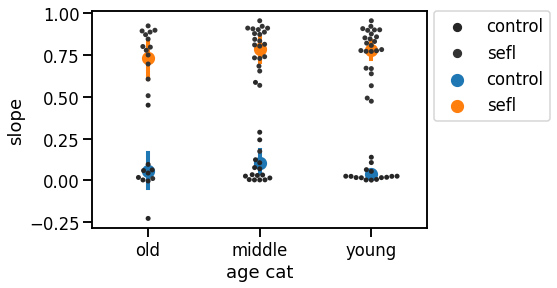

In [ ]:
df = df_select_age_slope[df_select_age_slope['day']=='sefla']
g = sns.swarmplot(data=df, x='age cat',y='slope', hue='condition',
              color='.2')

g = sns.pointplot(data=df, x='age cat',y='slope', hue='condition',
                   join=False)
g.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# g.get_legend().remove()

TODO: add the actual lines

In [ ]:
worksheet = gc.open('stim_interval_freezing_w_ELS_5_16_22').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(data)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace =True)
df.reset_index(inplace=True, drop=True)
df['cohort_id'] = df['cohort']+ '_'+ df['id']
df_acq = df

In [ ]:
df_acq.set_index('cohort_id', inplace=True)
df_acq.head(2)

,cohort,condition,els,sex,genotype,id,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10
cohort_id,,,,,,,,,,,,,,,,,
ptsd2_81,ptsd2,control,n,male,wt,81,0.46,3.08,7.83,2.7,2.7,0.75,5.87,2.04,3.67,4.71,3.85
ptsd2_82,ptsd2,control,n,male,wt,82,2.2,7.32,5.78,6.37,8.28,13.89,12.86,8.15,7.91,12.19,13.84


In [ ]:
df_learn_age = df_select_age_slope.join(df_acq.drop(labels=['cohort', 'condition', 'els', 'sex',
                                                            'genotype', 'id'], axis=1), how='inner')
df_learn_age.drop(labels=['index', 'id', 'exposure_mins', 'analyzed_duration',
                          'time', 'date_time', 'cohort',
                          'man_date_time', 'dob', 'age_at_SEFLA',
                          'date'], axis=1, inplace=True)
df_learn_age.head(2)

,freezing,genotype,day,condition,sex,els,age cat,slope,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10
cohort_id,,,,,,,,,,,,,,,,,,,
els1_921-2,3.93,wt,sefla,control,female,n,old,0.0176,0,2.58,6.76,5.1,1.67,3.55,1.76,5.71,4.68,9.05,1.2
els1_921-2,11.70,wt,seflb,control,female,n,old,0.0176,0,2.58,6.76,5.1,1.67,3.55,1.76,5.71,4.68,9.05,1.2


Melting

In [ ]:
df_long_learn_age = pd.melt(df_learn_age[df_learn_age['day']=='sefla'],
                            id_vars=['genotype', 'sex', 'els',
                                     'slope', 'age cat', 'condition'],
                            value_vars=['pre', 'shock01', 'shock02', 'shock03',
                                        'shock04', 'shock05', 'shock06', 'shock07',
                                        'shock08', 'shock09', 'shock10'],
                            ignore_index=False, value_name='freezing',
                            var_name='interval'
                                                                                )
df_long_learn_age['freezing'] = df_long_learn_age['freezing'].apply(pd.to_numeric)
df_long_learn_age.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,genotype,sex,els,slope,age cat,condition,interval,freezing
cohort_id,,,,,,,,
els1_921-2,wt,female,n,0.0176,old,control,pre,0.00
els1_921-3,wt,female,n,-0.0034,old,control,pre,1.65


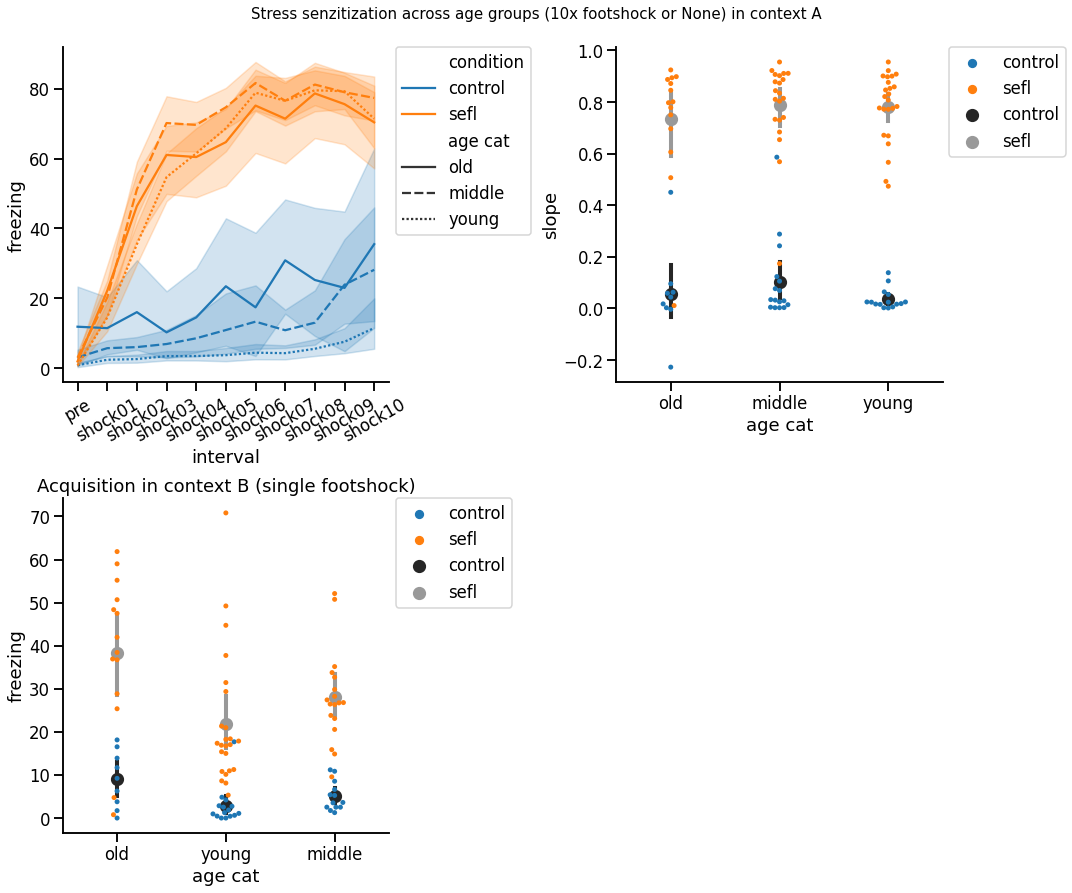

In [ ]:
#
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True,
                       figsize=(15, 12))
fig.suptitle("Stress senzitization across age groups (10x footshock or None) in context A",
             y=1.03,fontsize=15)
sns.despine()
# upper left
df = df_long_learn_age.reset_index()
g1 = sns.lineplot(data=df, x='interval', y='freezing',
             hue='condition', style='age cat', ax=ax[0][0])
g1.tick_params(axis='x', rotation=30)
g1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# upper right
df = df_select_age_slope[df_select_age_slope['day']=='sefla']
g2 = sns.swarmplot(data=df, x='age cat',y='slope', hue='condition',
              ax=ax[0][1])

g2 = sns.pointplot(data=df, x='age cat',y='slope', hue='condition',
                   join=False, ax=ax[0][1], color='.6')
g2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# lower left
df = df_select_age[df_select_age['day']=='seflb']

g2 = sns.swarmplot(data=df, x='age cat',y='freezing', hue='condition',
                   ax=ax[1][0])

g2 = sns.pointplot(data=df, x='age cat',y='freezing', hue='condition',
                   join=False, color='.6', ax=ax[1][0])
g2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g2.set_title('Acquisition in context B (single footshock)')
fig.delaxes(ax[1][1])

# plt.savefig(join(save_dir, 'Fear acq across age groups sefla and seflb.png'),
#             transparent=True, dpi=300, bbox_inches='tight')